# NBA Game Prediction - Exploratory Data Analysis

Quick EDA to understand our advanced features before modeling with Gradient Boosted Trees (XGBoost/LightGBM).

**Focus areas:**
1. Data quality checks
2. Target distribution (away win rate)
3. Feature distributions
4. Feature-target relationships
5. Temporal patterns
6. Multicollinearity analysis

## 1. Setup and Load Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)

print("Libraries loaded!")

Libraries loaded!


In [6]:
# Load the matchup data
df = pd.read_csv('nba_matchups_with_features.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Seasons: {df['season'].min()} - {df['season'].max()}")

Dataset shape: (5145, 143)
Date range: 2021-10-23 to 2025-06-22
Seasons: 2022 - 2025


In [7]:
# Define our feature sets (updated for advanced metrics)
# These are ALL differentials (away - home) for fair comparison

efficiency_features = [
    'off_rtg_L10_diff',      # Offensive Efficiency Gap
    'def_rtg_L10_diff',      # Defensive Efficiency Gap  
    'net_rtg_L10_diff',      # Overall Quality Gap
]

shooting_features = [
    'efg_pct_L10_diff',      # Shooting Efficiency Gap
    '3p_pct_L10_diff',       # 3-Point Shooting Gap
    '3pa_rate_L10_diff',     # 3-Point Volume Gap
]

form_features = [
    'win_pct_L10_diff',      # Recent Form Gap
    'win_streak_diff',       # Momentum Gap
]

control_features = [
    'to_pct_L10_diff',       # Ball Security Gap
    'ft_rate_L10_diff',      # Free Throw Gap
]

rebounding_playmaking_features = [
    'oreb_pct_L10_diff',     # Rebounding Gap
    'ast_ratio_L10_diff',    # Ball Movement Gap
]

defensive_features = [
    'stl_pct_L10_diff',      # Disruption Gap
    'blk_pct_L10_diff',      # Rim Protection Gap
]

consistency_features = [
    'pts_std_L10_diff',      # Consistency Gap (lower is more consistent)
]

context_features = [
    'rest_advantage',        # Rest Days Gap
    'is_b2b_home',          # Home Team Fatigue
    'is_b2b_away'           # Away Team Fatigue
]

all_features = (efficiency_features + shooting_features + form_features + 
                control_features + rebounding_playmaking_features + 
                defensive_features + consistency_features + context_features)

# Create target: win_away (1 if away team wins, 0 if home team wins)
target = 'win_away'

print(f"Total features: {len(all_features)}")
print(f"\nFeature breakdown:")
print(f"  • Efficiency metrics: {len(efficiency_features)}")
print(f"  • Shooting metrics: {len(shooting_features)}")
print(f"  • Form/momentum: {len(form_features)}")
print(f"  • Ball control: {len(control_features)}")
print(f"  • Rebounding/playmaking: {len(rebounding_playmaking_features)}")
print(f"  • Defense: {len(defensive_features)}")
print(f"  • Consistency: {len(consistency_features)}")
print(f"  • Context: {len(context_features)}")
print(f"\nTarget variable: {target} (predicting P(away team wins))")
print(f"\nNote: Pace excluded - all metrics are per-possession, making pace redundant")

Total features: 18

Feature breakdown:
  • Efficiency metrics: 3
  • Shooting metrics: 3
  • Form/momentum: 2
  • Ball control: 2
  • Rebounding/playmaking: 2
  • Defense: 2
  • Consistency: 1
  • Context: 3

Target variable: win_away (predicting P(away team wins))

Note: Pace excluded - all metrics are per-possession, making pace redundant


## 2. Data Quality Checks

In [8]:
# Missing values
missing = df[all_features + [target]].isnull().sum()
if missing.sum() > 0:
    print("Missing values:")
    print(missing[missing > 0])
else:
    print("✓ No missing values in features or target")

✓ No missing values in features or target


In [9]:
# Basic statistics
print("Feature summary statistics:")
df[all_features].describe().round(2)

Feature summary statistics:


,off_rtg_L10_diff,def_rtg_L10_diff,net_rtg_L10_diff,efg_pct_L10_diff,3p_pct_L10_diff,3pa_rate_L10_diff,win_pct_L10_diff,win_streak_diff,to_pct_L10_diff,ft_rate_L10_diff,oreb_pct_L10_diff,ast_ratio_L10_diff,stl_pct_L10_diff,blk_pct_L10_diff,pts_std_L10_diff,rest_advantage,is_b2b_home,is_b2b_away
count,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.0,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00,5145.00
mean,0.13,0.01,0.12,0.00,0.12,0.00,0.0,0.02,-0.02,0.00,-0.02,0.03,0.02,0.02,-0.03,-0.10,0.15,0.18
std,6.89,6.54,10.01,0.04,4.23,0.06,0.3,4.69,2.11,0.05,4.97,3.26,1.65,2.74,4.12,1.03,0.35,0.38
min,-24.01,-23.02,-39.06,-0.13,-18.46,-0.21,-1.0,-30.00,-8.65,-0.19,-17.28,-14.78,-7.20,-10.13,-24.72,-8.00,0.00,0.00
25%,-4.36,-4.25,-6.54,-0.03,-2.63,-0.04,-0.2,-3.00,-1.43,-0.03,-3.39,-2.15,-1.09,-1.85,-2.69,-1.00,0.00,0.00
50%,0.09,0.01,0.11,0.00,0.08,-0.00,0.0,0.00,-0.01,0.00,-0.11,0.05,0.01,0.02,-0.06,0.00,0.00,0.00
75%,4.90,4.29,6.86,0.03,2.94,0.04,0.2,3.00,1.37,0.03,3.35,2.23,1.07,1.84,2.59,0.00,0.00,0.00
max,28.29,27.13,40.51,0.14,19.15,0.22,1.0,27.00,8.40,0.37,20.94,11.20,7.86,16.44,23.33,8.00,1.00,1.00


## 3. Target Distribution

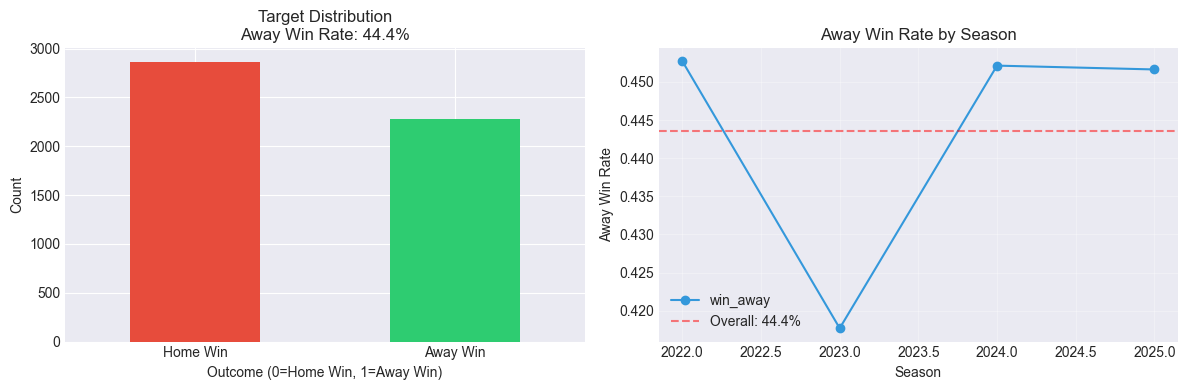


✓ Home court advantage (disadvantage for away team): 5.6 percentage points


In [10]:
# Away win rate
away_win_rate = df[target].mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
df[target].value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title(f'Target Distribution\nAway Win Rate: {away_win_rate:.1%}', fontsize=12)
axes[0].set_xlabel('Outcome (0=Home Win, 1=Away Win)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Home Win', 'Away Win'], rotation=0)

# Over time
away_win_by_season = df.groupby('season')[target].mean()
away_win_by_season.plot(ax=axes[1], marker='o', color='#3498db')
axes[1].axhline(away_win_rate, color='red', linestyle='--', alpha=0.5, label=f'Overall: {away_win_rate:.1%}')
axes[1].set_title('Away Win Rate by Season', fontsize=12)
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Away Win Rate')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Home court advantage (disadvantage for away team): {(0.5 - away_win_rate) * 100:.1f} percentage points")

## 4. Feature Distributions

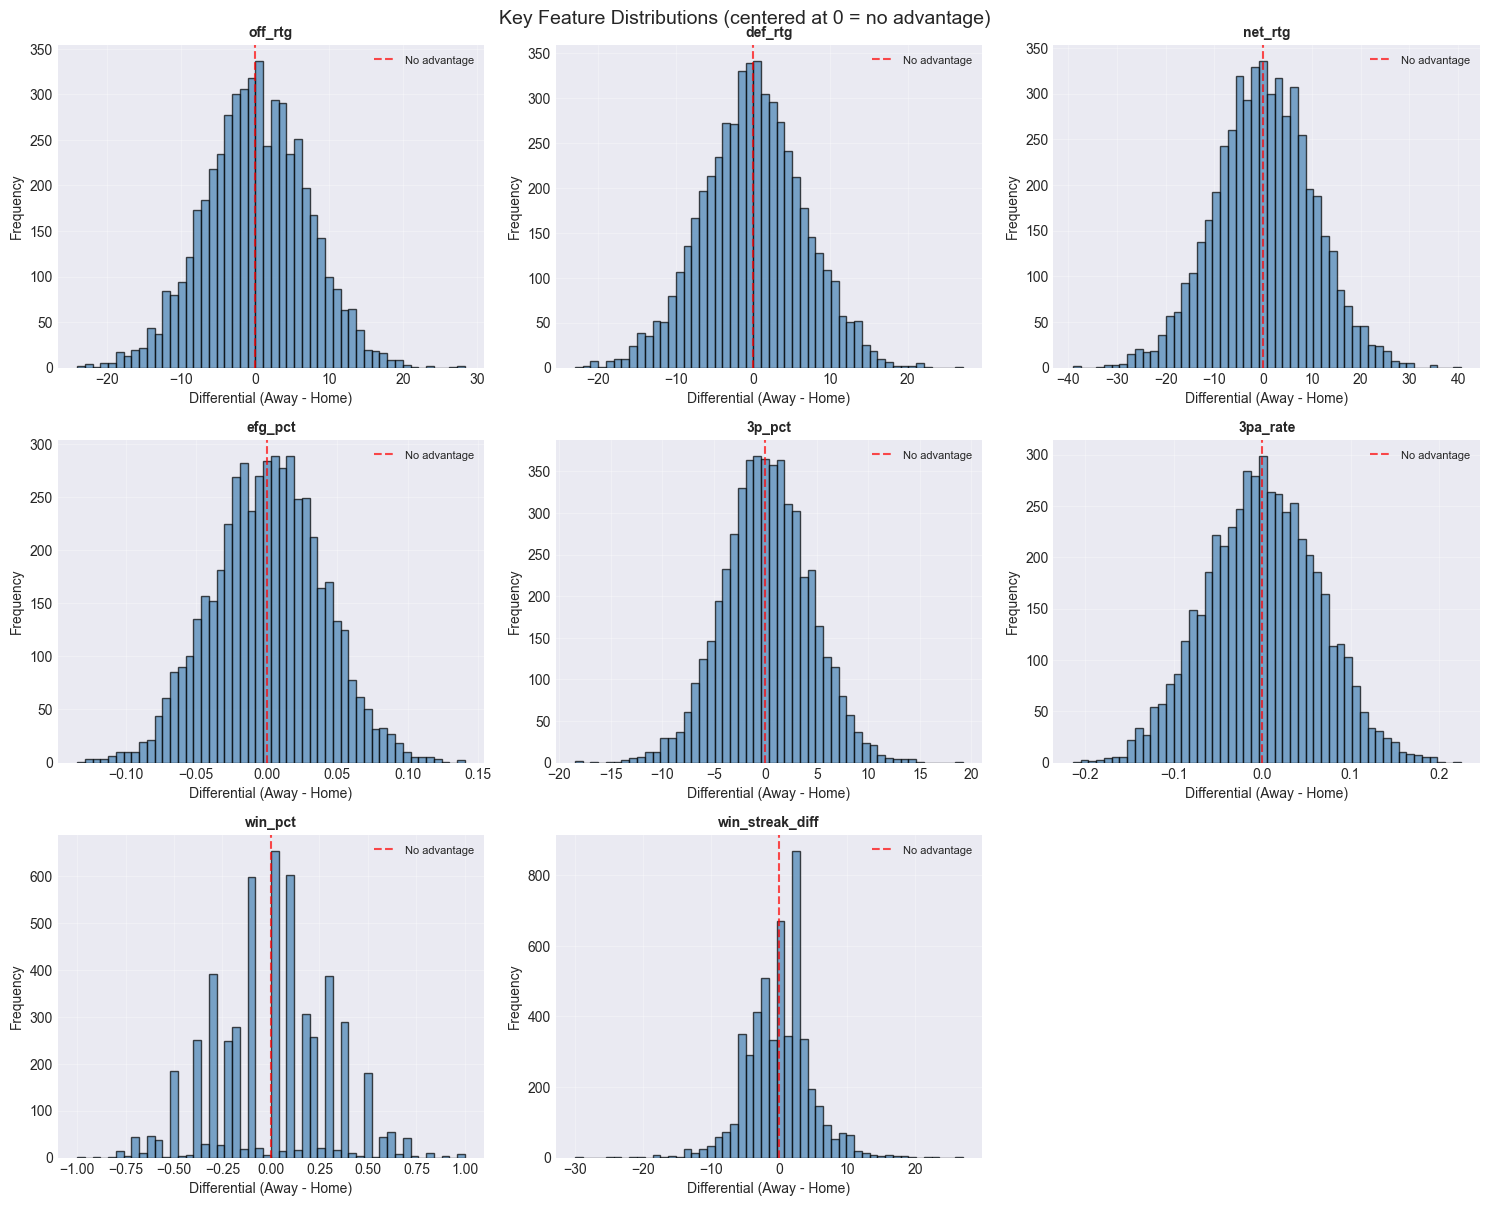

In [11]:
# Distribution of key features (efficiency, shooting, form)
key_features = efficiency_features + shooting_features + form_features

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    if i < len(axes):
        axes[i].hist(df[feature].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        axes[i].axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='No advantage')
        axes[i].set_title(feature.replace('_L10_diff', ''), fontsize=10, fontweight='bold')
        axes[i].set_xlabel('Differential (Away - Home)')
        axes[i].set_ylabel('Frequency')
        axes[i].legend(fontsize=8)
        axes[i].grid(alpha=0.3)

# Hide unused subplots
for i in range(len(key_features), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Key Feature Distributions (centered at 0 = no advantage)', fontsize=14, y=1.001)
plt.show()

## 5. Feature-Target Relationships

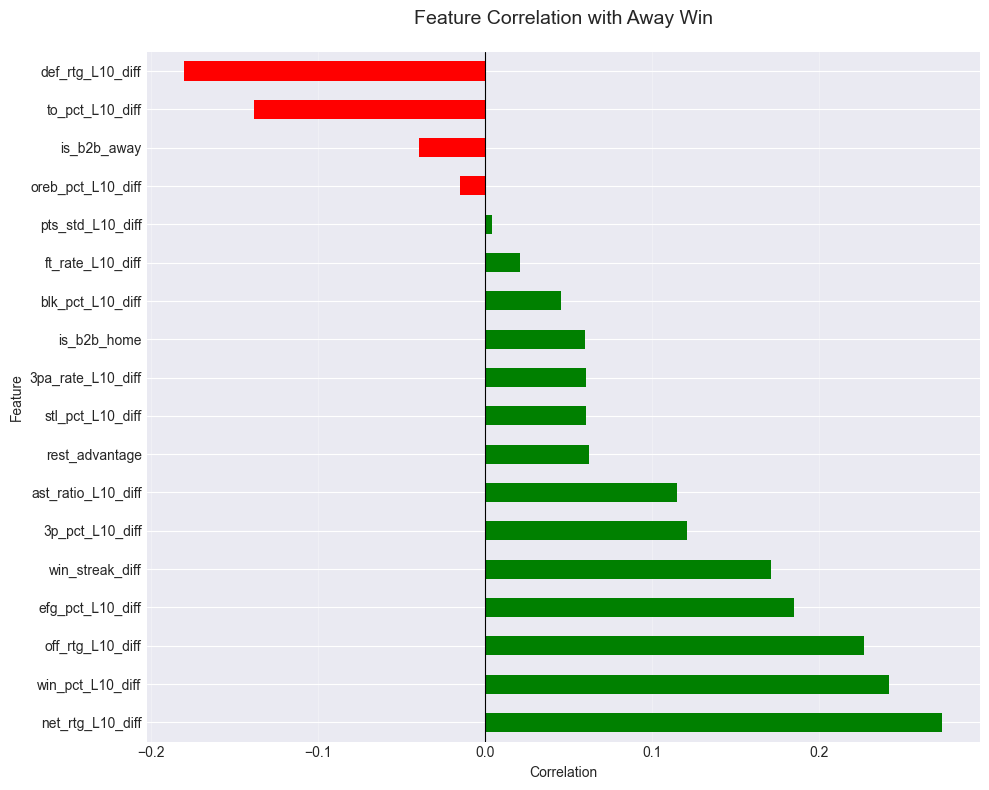


Top 5 most correlated features:
net_rtg_L10_diff    0.273567
win_pct_L10_diff    0.241584
off_rtg_L10_diff    0.226899
efg_pct_L10_diff    0.184732
win_streak_diff     0.171357
dtype: float64


In [12]:
# Correlation with target
correlations = df[all_features].corrwith(df[target]).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations])
plt.title('Feature Correlation with Away Win', fontsize=14, pad=20)
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 most correlated features:")
print(correlations.head())

/var/folders/m3/thpgvc7n5x7_ccm823g173000000gn/T/ipykernel_51075/805571238.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_q = df.groupby('quartile')[target].mean()
/var/folders/m3/thpgvc7n5x7_ccm823g173000000gn/T/ipykernel_51075/805571238.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_q = df.groupby('quartile')[target].mean()
/var/folders/m3/thpgvc7n5x7_ccm823g173000000gn/T/ipykernel_51075/805571238.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or ob

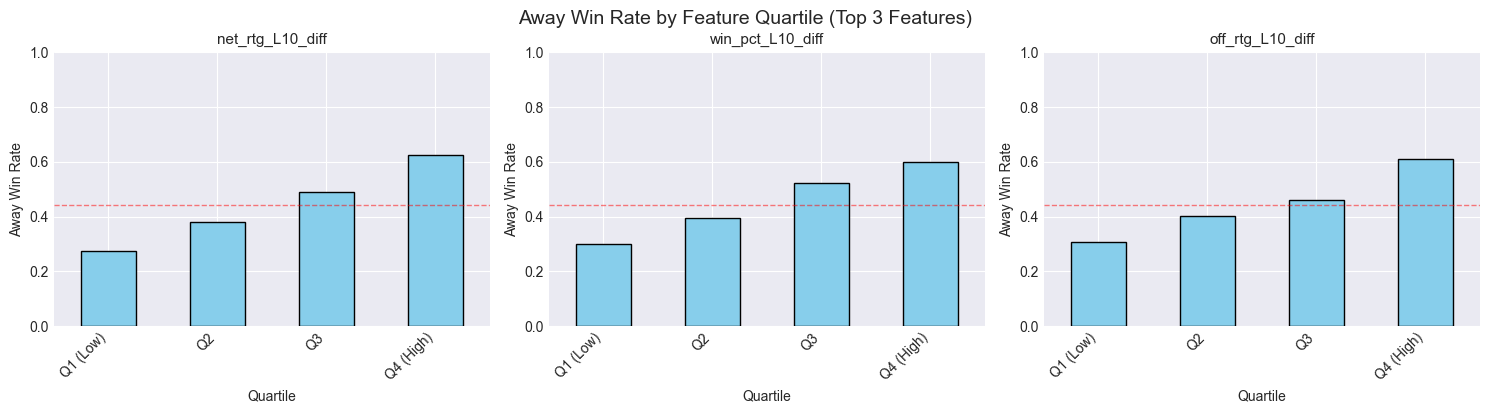

In [13]:
# Win rate by feature quartiles (top 3 features)
top_features = correlations.abs().nlargest(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(top_features):
    # Create quartiles
    df['quartile'] = pd.qcut(df[feature], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'], duplicates='drop')
    
    # Calculate win rate by quartile
    win_rate_by_q = df.groupby('quartile')[target].mean()
    
    win_rate_by_q.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{feature}', fontsize=11)
    axes[i].set_ylabel('Away Win Rate')
    axes[i].set_xlabel('Quartile')
    axes[i].axhline(away_win_rate, color='red', linestyle='--', alpha=0.5, linewidth=1)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.suptitle('Away Win Rate by Feature Quartile (Top 3 Features)', fontsize=14, y=1.02)
plt.show()

df.drop('quartile', axis=1, inplace=True)

## 6. Feature Relationships (Multicollinearity Check)

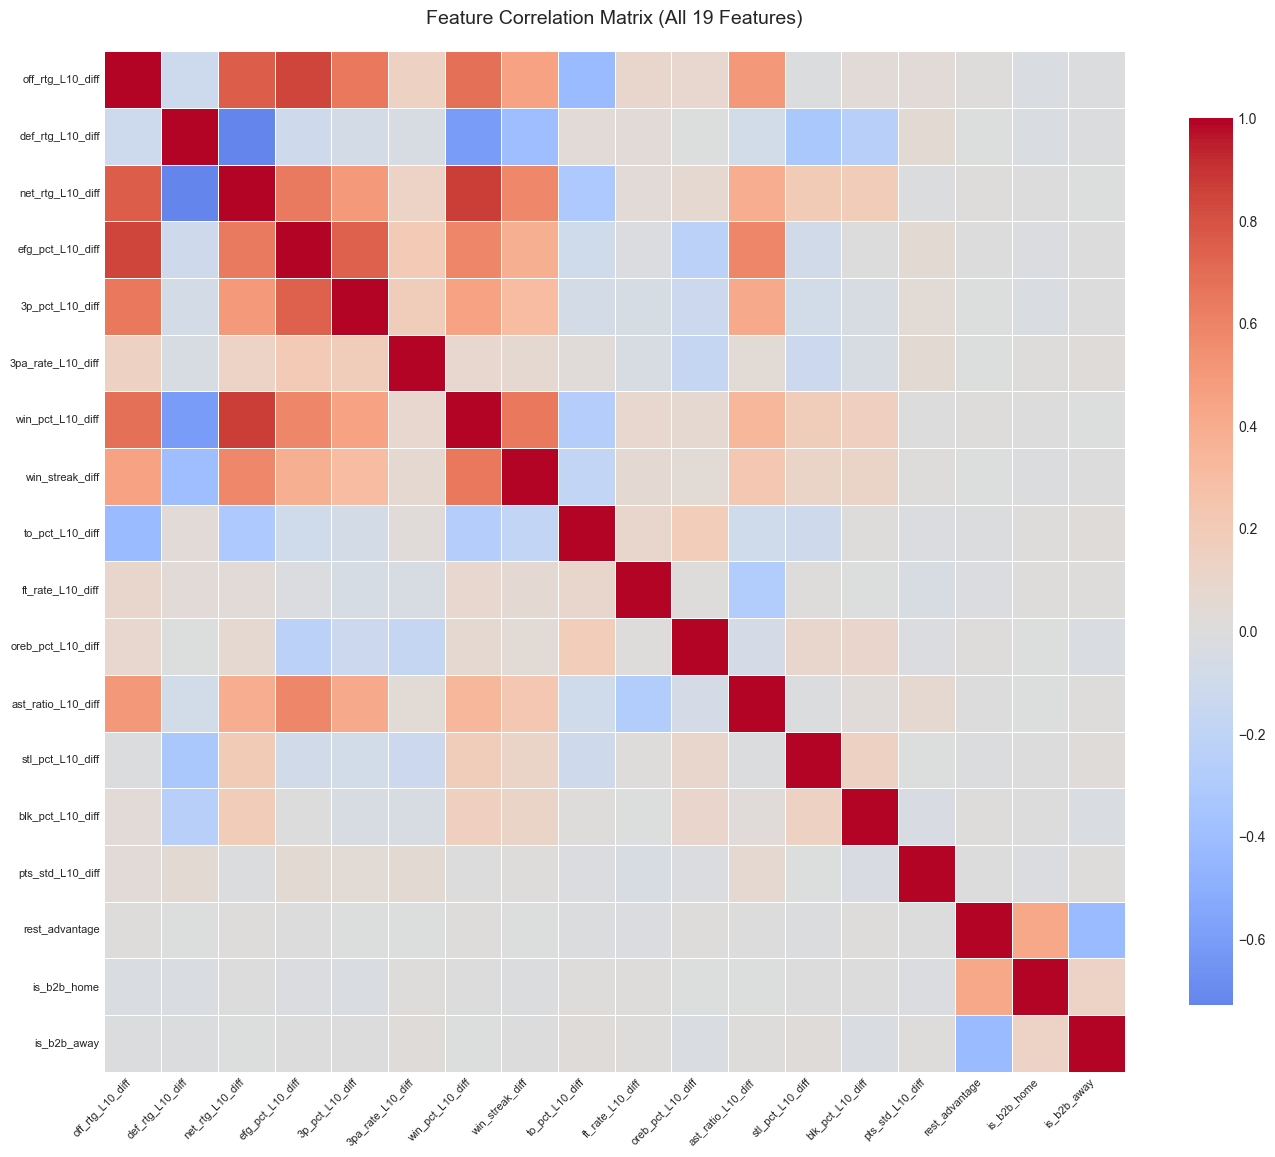


Highly correlated feature pairs (|r| > 0.7):
  off_rtg_L10_diff <-> net_rtg_L10_diff: 0.761
  off_rtg_L10_diff <-> efg_pct_L10_diff: 0.844
  def_rtg_L10_diff <-> net_rtg_L10_diff: -0.729
  net_rtg_L10_diff <-> win_pct_L10_diff: 0.869
  efg_pct_L10_diff <-> 3p_pct_L10_diff: 0.740

Note: Gradient boosted trees (XGBoost/LightGBM) handle multicollinearity well,
so we can keep correlated features. The model will learn which to prioritize.


In [14]:
# Correlation matrix for all features
corr_matrix = df[all_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix (All 19 Features)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("\nHighly correlated feature pairs (|r| > 0.7):")
    for f1, f2, corr in high_corr:
        print(f"  {f1} <-> {f2}: {corr:.3f}")
    print("\nNote: Gradient boosted trees (XGBoost/LightGBM) handle multicollinearity well,")
    print("so we can keep correlated features. The model will learn which to prioritize.")
else:
    print("\n✓ No highly correlated feature pairs (|r| > 0.7)")

## 7. Temporal Patterns

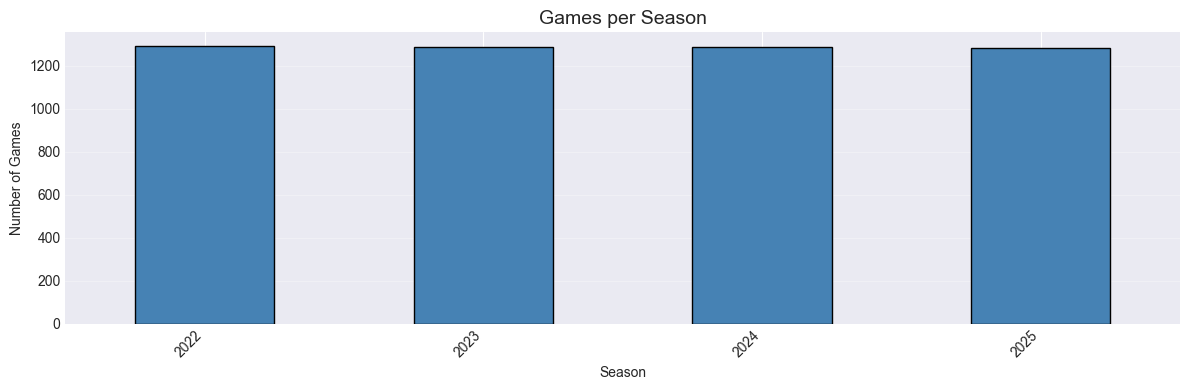

Average games per season: 1286
Min: 1282 (2025)
Max: 1290 (2022)


In [15]:
# Games per season
games_per_season = df.groupby('season').size()

plt.figure(figsize=(12, 4))
games_per_season.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Games per Season', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Average games per season: {games_per_season.mean():.0f}")
print(f"Min: {games_per_season.min()} ({games_per_season.idxmin()})")
print(f"Max: {games_per_season.max()} ({games_per_season.idxmax()})")

## 8. Train/Val/Test Split Preview

In [ ]:
# Time-based splits for modeling (updated for 2022+ data)
train = df[df['season'] <= 2023]
val = df[df['season'] == 2024]
test = df[df['season'] == 2025]

print("Recommended time-based splits (Season 2022+):")
print(f"\nTraining (2022 and 2023):     {len(train):,} games ({len(train)/len(df)*100:.1f}%)")
print(f"Validation (2024):   {len(val):,} games ({len(val)/len(df)*100:.1f}%)")
print(f"Test (2025):    {len(test):,} games ({len(test)/len(df)*100:.1f}%)")
print(f"\nTotal:               {len(df):,} games")

# Away win rates by split
print("\nAway win rates:")
if len(train) > 0:
    print(f"  Training:   {train[target].mean():.1%}")
if len(val) > 0:
    print(f"  Validation: {val[target].mean():.1%}")
if len(test) > 0:
    print(f"  Test:       {test[target].mean():.1%}")
    
print("\n✓ Time-based split ensures no data leakage")

Recommended time-based splits (Season 2022+):

Training (2022):     2,578 games (50.1%)
Validation (2023):   1,285 games (25.0%)
Test (2024-2025):    1,282 games (24.9%)

Total:               5,145 games

Away win rates:
  Training:   43.5%
  Validation: 45.2%
  Test:       45.2%

✓ Time-based split ensures no data leakage


## Summary

**Key Findings:**
1. ✓ No missing values in features
2. ✓ ~44% away win rate (home court advantage present)
3. ✓ Advanced efficiency metrics (off_rtg, def_rtg, net_rtg) are strong predictors
4. ✓ All features are differentials (away - home) for fair comparison
5. ✓ Data quality looks good across all seasons (2022-2025)
